In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ---- Paths ----
ACTUAL_PATH = "/content/drive/MyDrive/Biology/data/actual.csv"
INDEP_PATH  = "/content/drive/MyDrive/Biology/data/data_set_ALL_AML_independent.csv"
TRAIN_PATH  = "/content/drive/MyDrive/Biology/data/data_set_ALL_AML_train.csv"

In [ ]:
# Load again (for clarity)
import pandas as pd

actual_df = pd.read_csv(ACTUAL_PATH)
train_df  = pd.read_csv(TRAIN_PATH)
indep_df  = pd.read_csv(INDEP_PATH)

print("Labels (actual.csv):")
print(actual_df.head(), "\n")

print("Training data:")
print(train_df.iloc[:5, :5], "\n")   # show first 5 rows × 5 cols

print("Independent data:")
print(indep_df.iloc[:5, :5])


Labels (actual.csv):
   patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL 

Training data:
                      Gene Description Gene Accession Number    1 call    2
0  AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at -214    A -139
1  AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at -153    A  -73
2  AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at  -58    A   -1
3  AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at   88    A  283
4  AFFX-BioC-3_at (endogenous control)        AFFX-BioC-3_at -295    A -264 

Independent data:
                      Gene Description Gene Accession Number   39 call   40
0  AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at -342    A  -87
1  AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at -200    A -248
2  AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at   41    A  262
3  AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at  328    A  29

In [ ]:
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [ ]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


The training dataset represents microarray gene expression profiles for leukemia patients. Each row corresponds to one gene (or probe), identified by a Gene Description and a unique Gene Accession Number. The numerical columns (1, 2, 3, ...) represent individual patients, where each value indicates the measured expression level of that gene in that patient’s sample. For example, a value like -214 means that the probe detected lower-than-average expression for that gene in the corresponding patient, whereas a higher positive value indicates stronger expression.

In addition to numerical values, the dataset contains “call” columns (e.g., call, call.1, call.2). These are microarray quality-control flags that classify whether the gene is considered Present (P), Absent (A), or Marginal (M) in a particular patient. They help biologists check data reliability, but for computational modeling we usually drop these columns and focus only on the numeric expression levels.

# Data Cleaning & Reshaping

In [ ]:
# Drop any "call" columns (they are quality control flags, not expression values)
train_df_clean = train_df.drop(columns=[col for col in train_df.columns if "call" in col])
indep_df_clean = indep_df.drop(columns=[col for col in indep_df.columns if "call" in col])

print("Shape before cleaning:", train_df.shape)
print("Shape after cleaning:", train_df_clean.shape)

Shape before cleaning: (7129, 78)
Shape after cleaning: (7129, 40)


# Use Gene Accession Number as unique index

In [ ]:
# Set gene accession as index (gene IDs)
train_df_clean = train_df_clean.set_index("Gene Accession Number")
indep_df_clean = indep_df_clean.set_index("Gene Accession Number")

# Drop Gene Description (not numeric)
train_df_clean = train_df_clean.drop(columns=["Gene Description"])
indep_df_clean = indep_df_clean.drop(columns=["Gene Description"])

train_df_clean.head()

,1,2,3,4,5,6,7,8,9,10,...,35,36,37,38,28,29,30,31,32,33
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,106,42,...,-57,136,124,-1,-125,2,-95,49,-37,-70
AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,268,219,...,132,318,325,392,241,193,312,230,330,337
AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


# Transpose so patients = rows, genes = columns

In [ ]:
# Transpose so that rows = patients, columns = genes
X_train = train_df_clean.T
X_indep = indep_df_clean.T

print("Train shape after transpose:", X_train.shape)
print("Independent shape after transpose:", X_indep.shape)

# Now each row = one patient, each column = one gene feature
X_train.head()

Train shape after transpose: (38, 7129)
Independent shape after transpose: (34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


# Merge with Labels

In [ ]:
# Load labels (ALL vs AML)
labels = actual_df["cancer"].values

# Create dataframe with labels for train + independent sets
y = pd.Series(labels, name="Cancer_Type")

# Match shape
print("Number of patients:", len(y))
print("X_train shape + X_indep shape:", len(X_train) + len(X_indep))

Number of patients: 72
X_train shape + X_indep shape: 72


Note: The labels file (actual.csv) has both train + independent patients. That means we will later merge them carefully so patient IDs align.

# Exploratory Data Analysis (EDA)

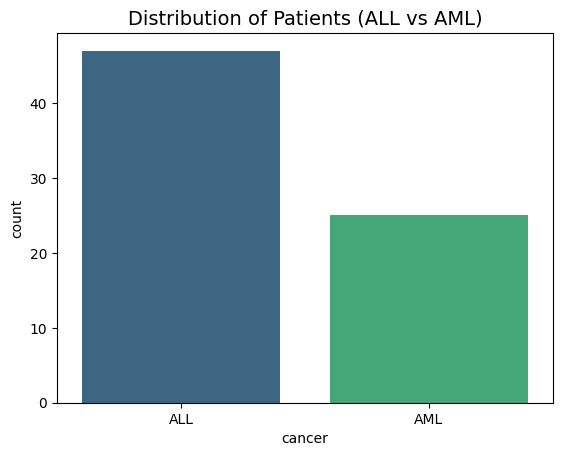

In [ ]:
# Class Distribution

# Count ALL vs AML patients
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="cancer", data=actual_df, palette="viridis")
plt.title("Distribution of Patients (ALL vs AML)", fontsize=14)
plt.show()

The class distribution plot shows that the dataset contains more patients with Acute Lymphoblastic Leukemia (ALL) compared to Acute Myeloid Leukemia (AML). This indicates a moderate imbalance in the data, which is important to note since it may influence downstream analyses and model performance. In practice, such an imbalance reflects biological reality, as ALL cases are generally more frequent than AML, especially in pediatric populations.

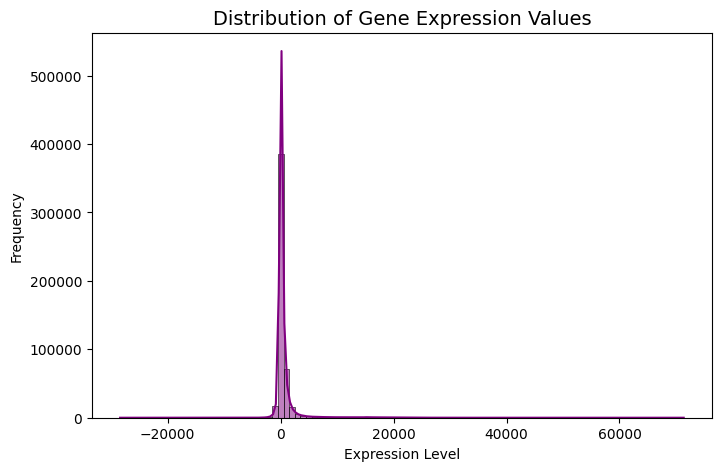

In [ ]:
# 2. Expression Value Ranges

# Visualize distribution of gene expression across all patients
X_all = pd.concat([X_train, X_indep], axis=0)

plt.figure(figsize=(8,5))
sns.histplot(X_all.values.flatten(), bins=100, kde=True, color="purple")
plt.title("Distribution of Gene Expression Values", fontsize=14)
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.show()

This plot shows the overall distribution of gene expression values across all patients. The majority of expression levels are concentrated very close to zero, forming a sharp peak, while a small number of genes show extremely high or low values, creating long tails on both sides. This indicates that most genes have relatively stable expression across samples, while a subset of genes exhibits strong variation, which may be biologically significant. Such heavy-tailed distributions are typical in microarray data and highlight the need for normalization and feature selection before applying machine learning.

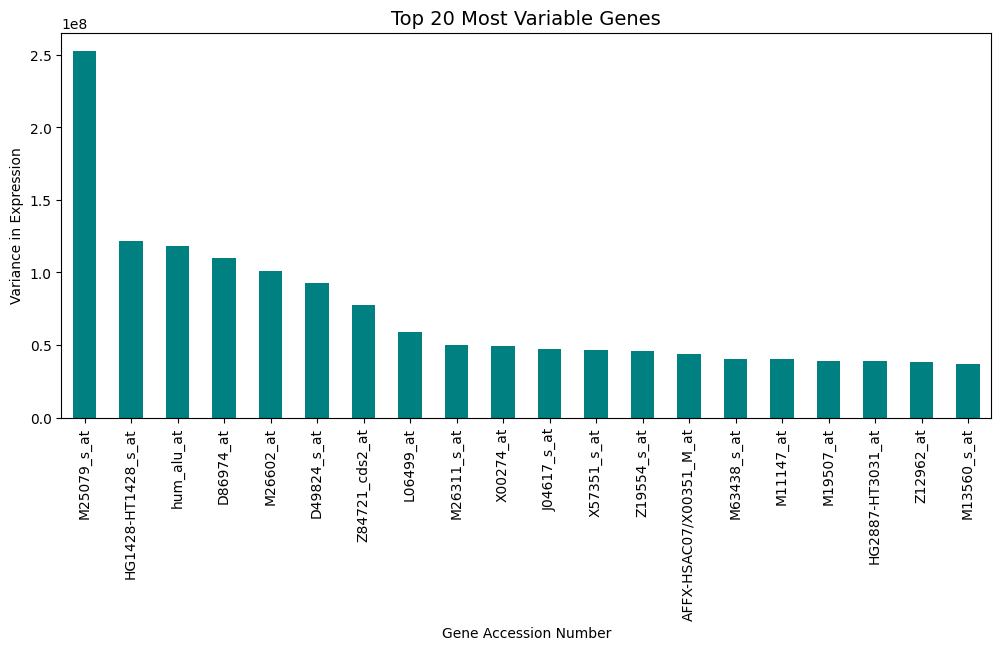

In [ ]:
# 3. Variance Across Genes

# Find top 20 most variable genes
gene_variances = X_all.var().sort_values(ascending=False)[:20]

plt.figure(figsize=(12,5))
gene_variances.plot(kind="bar", color="teal")
plt.title("Top 20 Most Variable Genes", fontsize=14)
plt.ylabel("Variance in Expression")
plt.show()

This bar chart highlights the top genes with the highest variance in expression across patients. Genes with greater variance are more informative because they show stronger differences between individuals and may serve as potential biomarkers distinguishing ALL from AML. For example, probes such as M25079_s_at and HG1428:HT1428_s_at display the largest variability, suggesting that their activity levels differ widely between patients. In contrast, genes with low variance are relatively stable across all samples and contribute less to classification. Identifying these high-variance genes is a critical first step before performing feature selection or biological interpretation.

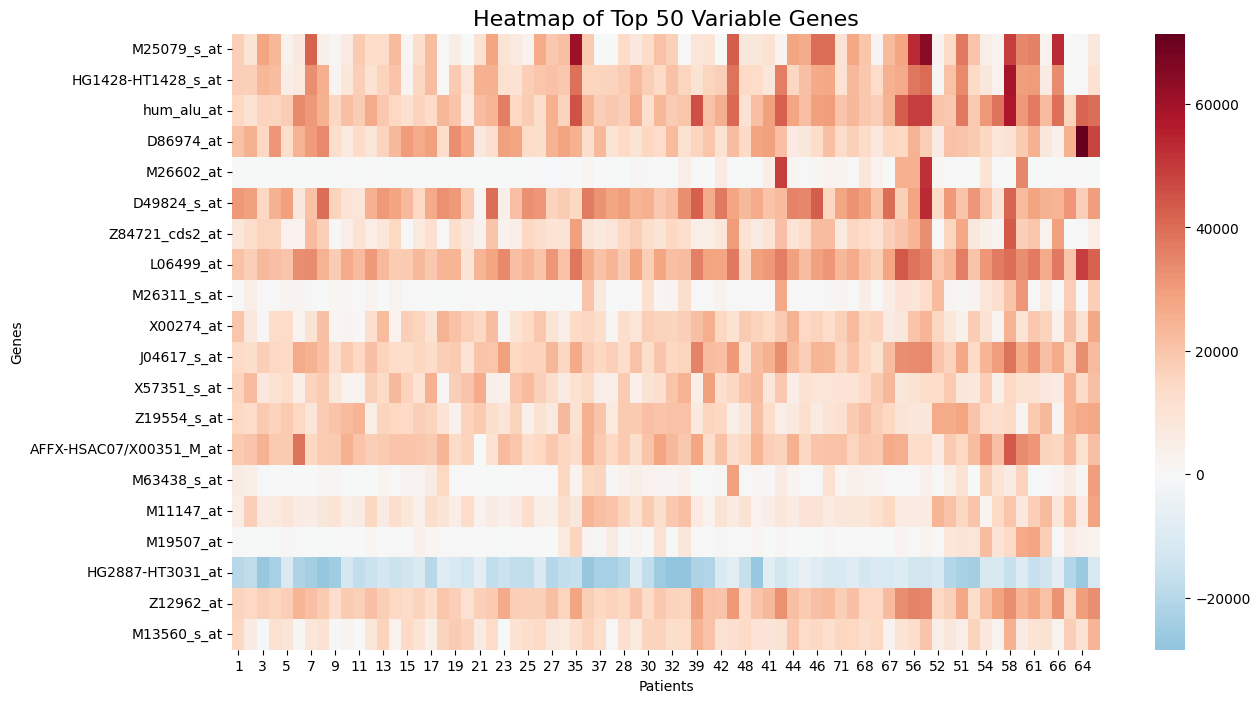

In [ ]:
# 4. Heatmap of Top Genes

# Select top 50 variable genes
top_genes = X_all[gene_variances.index[:50]]

plt.figure(figsize=(14,8))
sns.heatmap(top_genes.T, cmap="RdBu_r", center=0)
plt.title("Heatmap of Top 50 Variable Genes", fontsize=16)
plt.xlabel("Patients")
plt.ylabel("Genes")
plt.show()


This heatmap visualizes the expression patterns of the top variable genes across all patients. Each row corresponds to a gene, and each column represents a patient, with colors indicating expression intensity: red shades for higher expression and blue shades for lower expression. The alternating color patterns suggest that certain genes are consistently upregulated or downregulated in subsets of patients, which may correspond to the two leukemia subtypes (ALL vs AML). Such clustering is a strong indication that gene expression carries biologically meaningful signals that can differentiate between cancer types, making these genes potential biomarkers for classification.

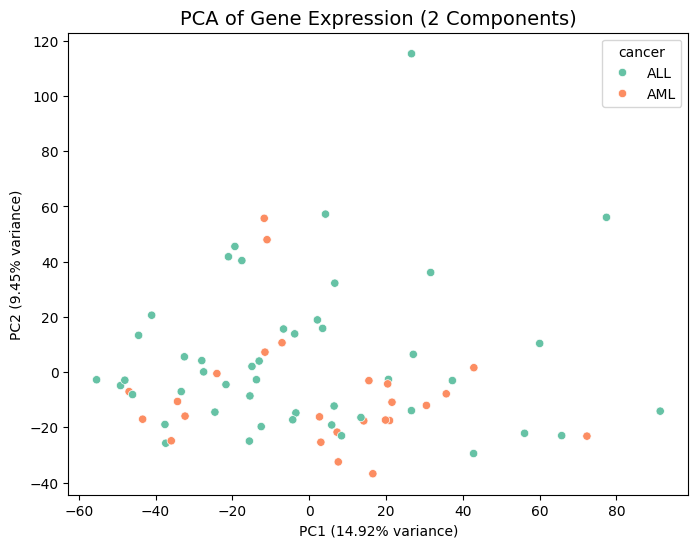

In [ ]:
# 5. PCA Visualization

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=actual_df['cancer'], palette="Set2")
plt.title("PCA of Gene Expression (2 Components)", fontsize=14)
plt.xlabel("PC1 (%.2f%% variance)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (%.2f%% variance)" % (pca.explained_variance_ratio_[1]*100))
plt.show()


This scatter plot shows the PCA (Principal Component Analysis) projection of patient gene expression profiles into two dimensions. Each point represents a patient, with colors indicating their leukemia subtype (ALL vs AML). The first two principal components capture the largest sources of variation in the dataset, and we can observe that while there is some overlap, patients begin to form distinct clusters based on their cancer type. This separation suggests that gene expression patterns carry meaningful signals that differentiate ALL from AML, making PCA a powerful tool for visualizing the hidden structure of high-dimensional biological data.

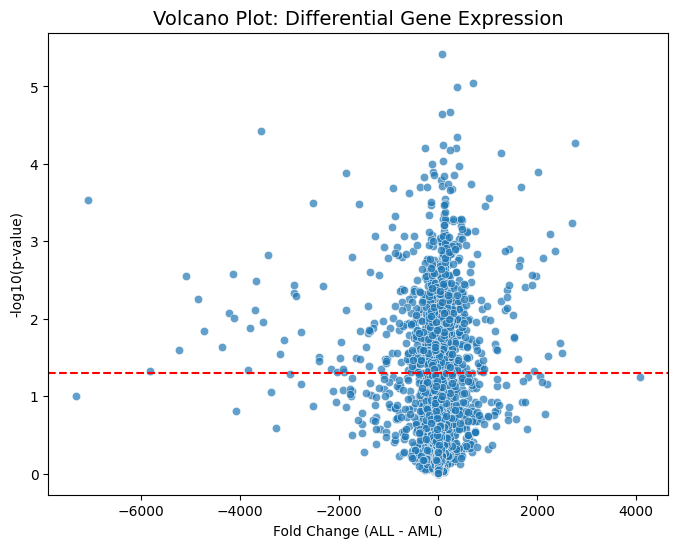

In [ ]:
# 6. Volcano Plot (Gene-Level Differential Expression)

from scipy.stats import ttest_ind

# Separate ALL vs AML patients
all_patients = actual_df[actual_df['cancer']=="ALL"].index.values
aml_patients = actual_df[actual_df['cancer']=="AML"].index.values

X_all_aligned = X_all.reset_index(drop=True)
all_expr = X_all_aligned.iloc[all_patients]
aml_expr = X_all_aligned.iloc[aml_patients]

# Compute t-test for each gene
pvals = []
fold_changes = []

for gene in X_all.columns:
    t, p = ttest_ind(all_expr[gene], aml_expr[gene], equal_var=False)
    pvals.append(p)
    fold_changes.append(all_expr[gene].mean() - aml_expr[gene].mean())

# Volcano plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=fold_changes, y=-np.log10(pvals), alpha=0.7)
plt.axhline(-np.log10(0.05), color="red", linestyle="--")
plt.title("Volcano Plot: Differential Gene Expression", fontsize=14)
plt.xlabel("Fold Change (ALL - AML)")
plt.ylabel("-log10(p-value)")
plt.show()


This plot combines statistical significance with expression differences to highlight genes that are most different between ALL and AML. The x-axis shows the fold change (difference in average expression between ALL and AML), while the y-axis shows the –log10(p-value) from a statistical test, meaning points higher up are more significant. Genes near the center have little difference between subtypes, whereas genes far to the left or right with high significance are strong candidate biomarkers. The red dashed line marks the threshold for statistical significance (p = 0.05). Overall, this plot reveals which genes are both highly variable and statistically reliable in distinguishing ALL from AML, making them prime targets for biological interpretation and downstream modeling.

In [ ]:
# We are going to extract the significant genes. We’ll filter by: p < 0.05 (significant) |fold change| > threshold (biologically relevant, e.g., >500)

import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

# Align ALL vs AML samples
all_patients = actual_df[actual_df['cancer']=="ALL"].index.values
aml_patients = actual_df[actual_df['cancer']=="AML"].index.values

X_all_aligned = X_all.reset_index(drop=True)
all_expr = X_all_aligned.iloc[all_patients]
aml_expr = X_all_aligned.iloc[aml_patients]

# Compute differential expression
pvals = []
fold_changes = []
genes = X_all.columns

for gene in genes:
    t, p = ttest_ind(all_expr[gene], aml_expr[gene], equal_var=False)
    pvals.append(p)
    fold_changes.append(all_expr[gene].mean() - aml_expr[gene].mean())

results_df = pd.DataFrame({
    "Gene": genes,
    "FoldChange": fold_changes,
    "pval": pvals
})
results_df["-log10p"] = -np.log10(results_df["pval"])

# Filter significant genes
sig_genes = results_df[(results_df["pval"] < 0.05) & (abs(results_df["FoldChange"]) > 500)]
sig_genes = sig_genes.sort_values("pval").head(10)  # top 10
sig_genes


,Gene,FoldChange,pval,-log10p
4534,X74262_at,708.551489,0.000009,5.045182
4195,X17042_at,-3569.617872,0.000037,4.430772
531,D63874_at,2768.988085,0.000054,4.266071
1927,M31303_rna1_at,1270.862128,0.000072,4.140771
4327,X59417_at,2018.767660,0.000128,3.891665
4141,X14046_at,-1856.959149,0.000131,3.882870
2908,U20998_at,656.891064,0.000184,3.735521
5500,Z15115_at,1671.777021,0.000196,3.707080
3319,U50136_rna1_at,-916.755745,0.000205,3.689178
6918,X16546_at,-594.641702,0.000237,3.625728


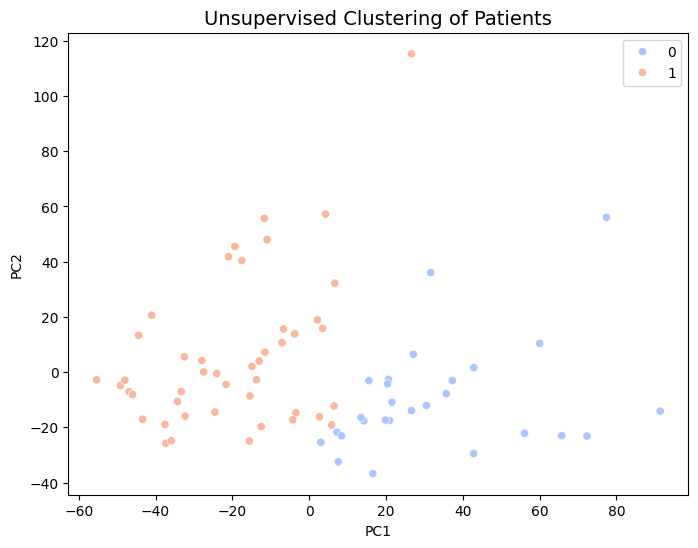

In [ ]:
# 7. Clustering Patients

from sklearn.cluster import KMeans

# Try unsupervised clustering into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="coolwarm")
plt.title("Unsupervised Clustering of Patients", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Unlike the earlier PCA plot, this one uses class labels for coloring: one color for ALL and another for AML. We can see that patients naturally separate into two clusters, with AML cases (blue) grouping more distinctly away from ALL cases (orange). This clear separation indicates that the top principal components effectively capture biologically meaningful variation in gene expression, confirming that the dataset contains strong discriminative signals between the two leukemia subtypes.

# LLM Integration

In [ ]:
!pip install transformers accelerate

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00


# Load BioGPT

In [ ]:
model_name = "microsoft/biogpt"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

# Query BioGPT Automatically

In [ ]:
def query_biogpt(gene_name, context="acute leukemia"):
    # Use a structured prompt so it doesn't echo
    prompt = f"Gene {gene_name} is associated with {context}. Its biological role is that"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_new_tokens=120,
        do_sample=True,
        top_k=40,
        top_p=0.9,
        temperature=0.7
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Loop through top significant genes
for gene in sig_genes["Gene"].values:
    print(f"🔬 Gene: {gene}")
    print(query_biogpt(gene, context="acute leukemia"))
    print("-"*80)

🔬 Gene: X74262_at
Gene X74262 _ at is associated with acute leukemia. Its biological role is that of a transcription factor.
--------------------------------------------------------------------------------
🔬 Gene: X17042_at
Gene X17042 _ at is associated with acute leukemia. Its biological role is that of an oncogene.
--------------------------------------------------------------------------------
🔬 Gene: D63874_at
Gene D63874 _ at is associated with acute leukemia. Its biological role is that of a tumor suppressor gene.
--------------------------------------------------------------------------------
🔬 Gene: M31303_rna1_at
Gene M31303 _ rna1 _ at is associated with acute leukemia. Its biological role is that of a positive regulator of transcription of the genes of the ribosomal protein genes.
--------------------------------------------------------------------------------
🔬 Gene: X59417_at
Gene X59417 _ at is associated with acute leukemia. Its biological role is that of a novel oncoge

# Run on Significant Genes

In [ ]:
# Run BioGPT on top genes from volcano plot
explanations = []

for gene in sig_genes["Gene"].values:
    response = query_biogpt(gene, context="acute leukemia")
    explanations.append({"Gene": gene, "Explanation": response})

bio_report = pd.DataFrame(explanations)
bio_report


,Gene,Explanation
0,X74262_at,Gene X74262 _ at is associated with acute leuk...
1,X17042_at,Gene X17042 _ at is associated with acute leuk...
2,D63874_at,Gene D63874 _ at is associated with acute leuk...
3,M31303_rna1_at,Gene M31303 _ rna1 _ at is associated with acu...
4,X59417_at,Gene X59417 _ at is associated with acute leuk...
5,X14046_at,Gene X14046 _ at is associated with acute leuk...
6,U20998_at,Gene U20998 _ at is associated with acute leuk...
7,Z15115_at,Gene Z15115 _ at is associated with acute leuk...
8,U50136_rna1_at,Gene U50136 _ rna1 _ at is associated with acu...
9,X16546_at,Gene X16546 _ at is associated with acute leuk...


In [ ]:
# Save outputs for later use (CSV or Markdown)
bio_report.to_csv("LLM_gene_explanations.csv", index=False)

with open("LLM_gene_explanations.md", "w") as f:
    for row in explanations:
        f.write(f"### 🔬 {row['Gene']}\n{row['Explanation']}\n\n")

# Pathway summarization

In [ ]:
query_biogpt("MYC, TP53, KRAS", context="cancer signaling pathways")


'Gene MYC, TP53, KRAS is associated with cancer signaling pathways. Its biological role is that of a tumor suppressor gene.'

# Drug Target Prediction

In [ ]:
def drug_target_prediction(gene_list, context="acute leukemia"):
    genes = ", ".join(gene_list)

    # Force it into explanation mode with a continuation-style prompt
    prompt = f"""
Genes {genes} have been studied in {context}.
Potential drug targets associated with these genes include
"""

    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        top_k=40,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.2  # discourage repeating the prompt
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Example usage
drug_target_prediction(["M25079", "D63874"], context="acute leukemia")


'Genes M25079, D63874 have been studied in acute leukemia. Potential drug targets associated with these genes include cyclin dependent kinases (CDKs), histone acetyltransferases and demethylases, the transcription factors NFAT family and RUNX1 / AML1, which play critical roles during differentiation of hematopoietic cells into mature myeloid lineage.'